In [1]:
import os
# go to the root of the project
if 'notebooks' in os.getcwd():
    os.chdir('../')
print(f'cwd: {os.getcwd()}')

cwd: /Users/gbemidebe/Documents/GitHub/RLseparation


In [2]:
import numpy as np

from scipy.integrate import odeint
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [3]:
# # Define the ODE loss function
# def reshape_input(a, t):
#     '''Reshape input tensors to match the dimensions of t'''
#     a_ = a.view(-1, 1).expand(-1, t.size(0))
#     return a_

# def ode(t, a, b):
#     '''ODE: dy/dt = a * exp(t) - b'''
#     out =  a * torch.exp(t).T - b
#     return out.flatten()

# # Known parameters a and b as vectors
# a = torch.tensor([1.0, 1.0, 1.0], requires_grad=True)
# b = torch.tensor([0.2, 0.25, 0.15], requires_grad=True)
# assert a.shape == b.shape
# t = torch.linspace(0, 0.5, 100).view(-1, 1).requires_grad_(True)
# result = ode(t, a = reshape_input(a, t), b= reshape_input(b, t)).reshape(len(a), len(t))
# print(t.shape, result.shape)

Given Ordinary differential equation, dy/dt = a * exp(t) - b. 

For combination of a, b, t and init (initial condition) and target k = y[-1] - y[0], develop a PINN for the model k = f(a, b, t, init).

loss = lambda_pinn * loss_physics + lambda_data * loss_neural_network



# 1. Solving ODE numerically

## A. Single parameters

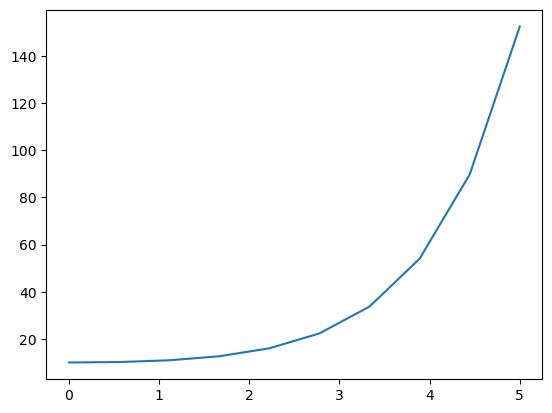

In [4]:
def ode(y, t, a, b):
    '''ODE: dy/dt = a * exp(t) - b'''
    dydt = a * np.exp(t) - b
    return dydt

initial = 10
a = 1
b = 1
t = np.linspace(0, 5, 10)
res = odeint(func=ode, y0=initial, t=t, args=(a, b))

plt.plot(t, res)

## B. Many parameters

In [5]:
a = np.array([1.0, 1.0, 1.0])
b = np.array([0.2, 0.2, 0.2])
t = np.array([6, 6, 6])
init = np.array([0, 25.5, 100.5])

def ode(t, y, a, b):
    '''ODE: dy/dt = a * exp(t) - b'''
    dydt = a * np.exp(t) - b
    return dydt

def fun_odeint(t, a, b, init, num_points=100):
    '''solve the ODE for multiple sets of parameters
    params:
        t: array of time points
        a: array of a parameters
        b: array of b parameters
        init: array of initial values
        num_points: number of points to solve
    returns:
        array of solutions
    '''
    assert a.shape == b.shape == t.shape == init.shape, 'Shapes of input arrays do not match'
    result = []
    for index in range(len(a)):
        params = (a[index], b[index])
        time = np.linspace(0, t[index], num_points)
        res = odeint(func=ode, y0=init[index], t=time, args=params, tfirst=True)
        result.append(res)

    return np.array(result)

def fun_ode_svp(t, a, b, init, num_points=100):
    '''solve the ODE for multiple sets of parameters
    params:
        t: array of time points
        a: array of a parameters
        b: array of b parameters
        init: array of initial values
        num_points: number of points to solve
    returns:
        array of solutions
    '''
    assert a.shape == b.shape == t.shape == init.shape, 'Shapes of input arrays do not match'
    result = []
    for index in range(len(a)):
        params = (a[index], b[index])
        tspan = (0, t[index])
        time = np.linspace(0, t[index], num_points)
        # lorenz, t_span, y0,
        print(init[index])  
        res = solve_ivp(fun=ode, y0=[init[index]], t_span=tspan, t_eval=time, args=params)
        print(res.y.shape)
        result.append(res.y.reshape(-1))

    return np.array(result)

pts = 10
res = fun_odeint(t=t, a=a, b=b, init=init, num_points=pts)
# res2 = fun_ode_svp(t=t, a=a, b=b, init=init, num_points=pts)
# print(res.shape, res2.shape)

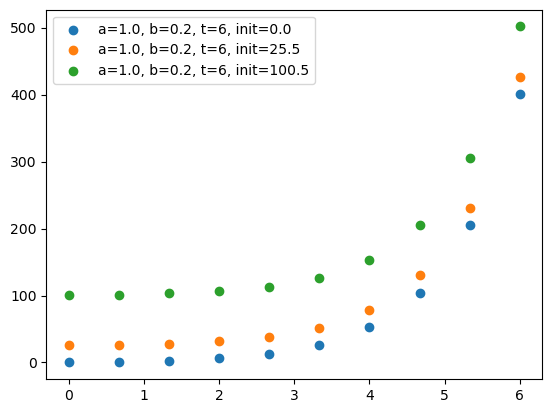

In [6]:
plt.scatter(np.linspace(0, t[0], pts), res[0], label=f'a={a[0]}, b={b[0]}, t={t[0]}, init={init[0]}')
plt.scatter(np.linspace(0, t[1], pts), res[1], label=f'a={a[1]}, b={b[1]}, t={t[1]}, init={init[1]}')
plt.scatter(np.linspace(0, t[2], pts), res[2], label=f'a={a[2]}, b={b[2]}, t={t[2]}, init={init[2]}')

plt.legend()

# 2. Neural Network (NN)

## A. ordinary NN

In [7]:
import torch.nn.functional as F

class FCN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
import numpy as np
x = np.random.rand(100, 10)
x = torch.tensor(x, dtype=torch.float32)
model = FCN(input_size=x.shape[1], hidden_size=20, output_size=1)
output = model(x)
print(x.shape, output.shape)

torch.Size([100, 10]) torch.Size([100, 1])


## B. Physics Neural Network

Reasoning: \
    params:\
    FCN or ODE has inputs: t (len = 100), a (len = 2) , b (len = 2) \
    ODE or FCN output should have same output. shape must be (len(t)*len(a), 1)

In [8]:
!pwd

/Users/gbemidebe/Documents/GitHub/RLseparation


 12%|█▏        | 120/1000 [00:00<00:01, 597.90it/s]

Epoch 0: physics = 36609.465, data = 111403.672, total = 103924.250
Epoch 10: physics = 36600.660, data = 111376.602, total = 103899.000
Epoch 20: physics = 36588.691, data = 111339.461, total = 103864.383
Epoch 30: physics = 36567.363, data = 111273.227, total = 103802.633
Epoch 40: physics = 36524.547, data = 111139.539, total = 103678.039
Epoch 50: physics = 36436.977, data = 110870.523, total = 103427.164
Epoch 60: physics = 36264.312, data = 110347.375, total = 102939.062
Epoch 70: physics = 35938.402, data = 109377.234, total = 102033.352
Epoch 80: physics = 35366.992, data = 107660.250, total = 100430.922
Epoch 90: physics = 34411.285, data = 104775.656, total = 97739.211
Epoch 100: physics = 32911.266, data = 100197.273, total = 93468.672
Epoch 110: physics = 30686.408, data = 93378.375, total = 87109.180
Epoch 120: physics = 27604.527, data = 83937.531, total = 78304.227


 24%|██▍       | 242/1000 [00:00<00:01, 604.44it/s]

Epoch 130: physics = 23714.955, data = 71977.453, total = 67151.203
Epoch 140: physics = 19466.904, data = 58627.812, total = 54711.723
Epoch 150: physics = 15722.488, data = 46240.930, total = 43189.086
Epoch 160: physics = 13489.593, data = 37438.027, total = 35043.184
Epoch 170: physics = 12617.140, data = 31672.496, total = 29766.961
Epoch 180: physics = 11691.281, data = 27165.369, total = 25617.961
Epoch 190: physics = 9674.257, data = 23667.693, total = 22268.350
Epoch 200: physics = 7657.089, data = 20572.525, total = 19280.980
Epoch 210: physics = 6277.338, data = 17686.738, total = 16545.799
Epoch 220: physics = 5356.044, data = 15193.737, total = 14209.968
Epoch 230: physics = 4600.972, data = 13224.231, total = 12361.905
Epoch 240: physics = 3885.905, data = 11374.577, total = 10625.710
Epoch 250: physics = 3275.414, data = 9458.490, total = 8840.182


 37%|███▋      | 368/1000 [00:00<00:01, 615.71it/s]

Epoch 260: physics = 2601.658, data = 7536.125, total = 7042.678
Epoch 270: physics = 1970.964, data = 5685.256, total = 5313.827
Epoch 280: physics = 1378.884, data = 3984.308, total = 3723.765
Epoch 290: physics = 884.882, data = 2545.093, total = 2379.072
Epoch 300: physics = 502.028, data = 1446.384, total = 1351.948
Epoch 310: physics = 248.840, data = 710.661, total = 664.479
Epoch 320: physics = 110.589, data = 300.642, total = 281.637
Epoch 330: physics = 47.622, data = 108.553, total = 102.460
Epoch 340: physics = 26.743, data = 38.778, total = 37.574
Epoch 350: physics = 22.445, data = 20.498, total = 20.693
Epoch 360: physics = 22.505, data = 17.726, total = 18.204
Epoch 370: physics = 22.784, data = 17.737, total = 18.242
Epoch 380: physics = 22.610, data = 17.647, total = 18.144


 49%|████▉     | 490/1000 [00:00<00:00, 579.87it/s]

Epoch 390: physics = 22.185, data = 17.427, total = 17.903
Epoch 400: physics = 21.843, data = 17.262, total = 17.721
Epoch 410: physics = 21.610, data = 17.146, total = 17.592
Epoch 420: physics = 21.455, data = 17.033, total = 17.476
Epoch 430: physics = 21.340, data = 16.915, total = 17.358
Epoch 440: physics = 21.229, data = 16.797, total = 17.240
Epoch 450: physics = 21.114, data = 16.680, total = 17.124
Epoch 460: physics = 20.990, data = 16.565, total = 17.008
Epoch 470: physics = 20.863, data = 16.451, total = 16.893
Epoch 480: physics = 20.736, data = 16.338, total = 16.778
Epoch 490: physics = 20.608, data = 16.225, total = 16.664
Epoch 500: physics = 20.482, data = 16.113, total = 16.550


 61%|██████    | 607/1000 [00:01<00:00, 574.37it/s]

Epoch 510: physics = 20.357, data = 16.001, total = 16.437
Epoch 520: physics = 20.233, data = 15.890, total = 16.324
Epoch 530: physics = 20.110, data = 15.779, total = 16.212
Epoch 540: physics = 19.986, data = 15.668, total = 16.100
Epoch 550: physics = 19.864, data = 15.558, total = 15.989
Epoch 560: physics = 19.741, data = 15.449, total = 15.878
Epoch 570: physics = 19.619, data = 15.340, total = 15.768
Epoch 580: physics = 19.499, data = 15.231, total = 15.658
Epoch 590: physics = 19.378, data = 15.123, total = 15.548
Epoch 600: physics = 19.256, data = 15.015, total = 15.439
Epoch 610: physics = 19.138, data = 14.908, total = 15.331
Epoch 620: physics = 19.019, data = 14.801, total = 15.223


 73%|███████▎  | 726/1000 [00:01<00:00, 540.13it/s]

Epoch 630: physics = 18.901, data = 14.694, total = 15.115
Epoch 640: physics = 18.784, data = 14.588, total = 15.008
Epoch 650: physics = 18.667, data = 14.483, total = 14.901
Epoch 660: physics = 18.550, data = 14.377, total = 14.795
Epoch 670: physics = 18.434, data = 14.272, total = 14.689
Epoch 680: physics = 18.319, data = 14.168, total = 14.583
Epoch 690: physics = 18.009, data = 14.039, total = 14.436
Epoch 700: physics = 17.275, data = 13.469, total = 13.850
Epoch 710: physics = 16.146, data = 12.412, total = 12.786
Epoch 720: physics = 14.676, data = 10.968, total = 11.339


 85%|████████▍ | 849/1000 [00:01<00:00, 574.02it/s]

Epoch 730: physics = 13.137, data = 9.328, total = 9.709
Epoch 740: physics = 11.683, data = 7.671, total = 8.072
Epoch 750: physics = 10.468, data = 6.128, total = 6.562
Epoch 760: physics = 9.481, data = 4.812, total = 5.279
Epoch 770: physics = 8.873, data = 3.750, total = 4.262
Epoch 780: physics = 8.422, data = 2.958, total = 3.505
Epoch 790: physics = 8.189, data = 2.404, total = 2.982
Epoch 800: physics = 8.109, data = 2.018, total = 2.627
Epoch 810: physics = 8.098, data = 1.770, total = 2.402
Epoch 820: physics = 8.132, data = 1.598, total = 2.251
Epoch 830: physics = 8.184, data = 1.478, total = 2.149
Epoch 840: physics = 8.191, data = 1.390, total = 2.070
Epoch 850: physics = 8.215, data = 1.316, total = 2.006


 97%|█████████▋| 972/1000 [00:01<00:00, 591.04it/s]

Epoch 860: physics = 8.244, data = 1.248, total = 1.948
Epoch 870: physics = 8.270, data = 1.184, total = 1.892
Epoch 880: physics = 8.290, data = 1.125, total = 1.842
Epoch 890: physics = 8.289, data = 1.072, total = 1.793
Epoch 900: physics = 8.280, data = 1.021, total = 1.747
Epoch 910: physics = 8.272, data = 0.973, total = 1.703
Epoch 920: physics = 8.275, data = 0.925, total = 1.660
Epoch 930: physics = 8.275, data = 0.880, total = 1.620
Epoch 940: physics = 8.286, data = 0.836, total = 1.581
Epoch 950: physics = 8.285, data = 0.795, total = 1.544
Epoch 960: physics = 8.284, data = 0.756, total = 1.508
Epoch 970: physics = 8.312, data = 0.715, total = 1.474
Epoch 980: physics = 8.310, data = 0.679, total = 1.442


100%|██████████| 1000/1000 [00:01<00:00, 581.54it/s]


Epoch 990: physics = 8.309, data = 0.644, total = 1.410


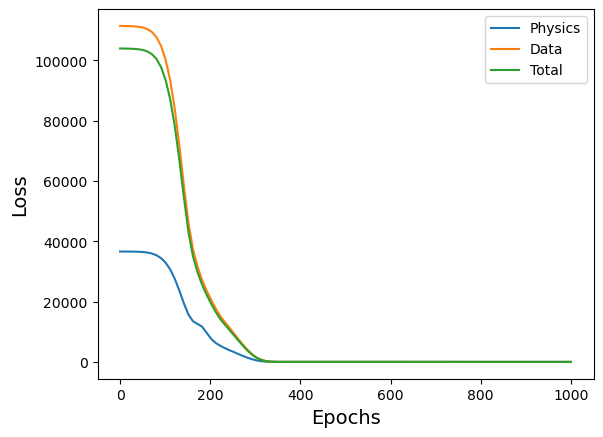

In [12]:
import numpy as np
from scipy.integrate import odeint
from scipy.stats import qmc

from sklearn.preprocessing import MinMaxScaler
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

class FCN(nn.Module):
    '''Fully connected neural network'''
    def __init__(self, input_size, hidden_neurons, n_layers, output_size):
        '''Initialize the neural network
        Args:
            int input_size: number of input features
            int hidden_size: number of hidden units
            int output_size: number of output features
        '''
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_neurons)
        self.fci = nn.ModuleList([nn.Linear(hidden_neurons, hidden_neurons) for i in range(n_layers)])
        self.fc2 = nn.Linear(hidden_neurons, output_size)

    def forward(self, x):
        '''Forward pass of the neural network
        Args:
            variable x: input tensor of shape (n, input_size)
        Returns:
            variable out: output tensor of shape (n, output_size)
        '''
        x = F.relu(self.fc1(x))
        for fc in self.fci:
            x = F.relu(fc(x))
        x = self.fc2(x)
        return x
    
class PNN(nn.Module):
    '''Physics-informed neural network'''
    def __init__(self, input_size, hidden_size, n_layers, output_size):
        '''Initialize the PINN
        Args:
            int input_size: number of input features
            int hidden_size: number of hidden units
            int output_size: number of output features
        '''
        super(PNN, self).__init__()
        self.input_size = input_size
        self.fcn = FCN(input_size, hidden_size, n_layers, output_size)
    
    def preprocess_input(self, data, first_time=False):
        '''Preprocess the input data to scale to (0, 1)'''

        (t, a, b, c) = data
        assert a.shape == b.shape == t.shape == c.shape, 'Shapes of input arrays do not match'

        x = np.column_stack(data)

        if first_time:
            # instantiate MinMaxScaler
            scaler = MinMaxScaler(feature_range=(0, 1))
            # fit and transform the data
            x_scaled = scaler.fit_transform(x)
            # save the scaler to a pickle file
            with open('./models/scaler.pkl', 'wb') as f:
                pickle.dump(scaler, f)
        else:
            # load the scaler from the pickle file
            with open('./models/scaler.pkl', 'rb') as f:
                scaler = pickle.load(f)
            # transform the data
            x_scaled = scaler.transform(x)

        return x_scaled
    
    def ode(self, t, y, a, b):
        '''ODE: 
        dy/dt = a * exp(t) - b'''
        dydt = a * np.exp(t) - b
        return dydt
    
    def SR(self, result):

        return result[-1] - result[0]
    
    def physics(self, data: tuple, num_points: int=10):
        '''solve the ODE for multiple sets of parameters
        params:
            data: tuple of input data (t, a, b, init)
            num_points: number of points to solve
        returns:
            array of solutions
        '''
        (t, a, b, init) = data
        assert a.shape == b.shape == t.shape == init.shape, 'Shapes of input arrays do not match'
        result = []
        for index in range(len(a)):
            params = (a[index], b[index])
            time = np.linspace(0, t[index], num_points)
            res = odeint(func=self.ode, y0=init[index], t=time, args=params, tfirst=True)
            result.append(self.SR(res))

        # print(f'physics output: {np.array(result).shape}')
        return torch.tensor(np.array(result), dtype=torch.float32)
    
    def forward(self, data):
        '''Feedforward function for the FCN using a and b as input
        Args:
            variable data: tuple of input data (t, a, b, c)
        Returns:
            variable out: tensor of shape (n, 1)
        '''
        # print(f'input in forward pass: {data.shape}')
        x = torch.tensor(data, dtype=torch.float32)
        out = self.fcn(x)
        return out

    def augment(self, data, n_samples=10):
        '''Apply Latin Hypercube Sampling to the input data to generate more samples
        (a, b, t, init) = data
        '''

        original_data = np.vstack(data).T
        # obtain the range of each parameter
        l_bound = np.array([a.min(), b.min(), t.min(), init.min()])
        u_bound = np.array([a.max(), b.max(), t.max(), init.max()])
        # check if the bounds are the same
        assert len(l_bound) == len(u_bound), 'Lower and upper bounds do not match'
        # apply Latin Hypercube Sampling
        sampler = qmc.LatinHypercube(d=len(l_bound))
        design_space = sampler.random(n_samples)
        # convert the LHS samples (0, 1) to the actual range
        new_design = qmc.scale(design_space, l_bound, u_bound)
        # merge the new samples with the original data and reshuflle
        augmented_data = np.vstack((original_data, new_design))
        np.random.shuffle(augmented_data)

        return (augmented_data[:, 0], augmented_data[:, 1], augmented_data[:, 2], augmented_data[:, 3])

    
    def training_step(self, 
                      inputs: tuple,
                      target: np.array,
                      lambda_pinn: float= 0.5,
                      lambda_data: float= 0.5,
                      epoch: int = 1000):
        '''Compute the loss function for the PINN'''
        # convert target to tensor
        y = torch.tensor(target, dtype=torch.float32).reshape(-1, 1)
        # augment the data for physics loss to enhance the training
        phys_augmented = self.augment(inputs, n_samples=10)
        # rescale the inputs to (0, 1) and write the scaler to yaml file
        inputs = self.preprocess_input(inputs, first_time=True)
        phys_augmented_norm = self.preprocess_input(phys_augmented)
        # print(f'preprocessed actual input in training: {inputs.shape}, target: {y.shape}')
        # print(f'preprocessed augmented input in training: {inputs_augmented[0].shape}')
    
        # optimizer and loss function
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        loss_fn_physics = nn.MSELoss()
        loss_fn_data = nn.MSELoss()
        # record for loss function
        recorder_epoch_physics = []
        recorder_epoch_data = []
        recorder_epoch_total = []
        for epoch in tqdm(range(epoch)):
            optimizer.zero_grad()
            # data driven loss
            out_nn = self(inputs)
            # print(f'output in training: {out_nn.shape}, target: {y.shape}')
            loss_data = loss_fn_data(out_nn, y)
            # physics loss
            out_phy_augmented = self.physics(phys_augmented)
            out_nn_augmented = self(phys_augmented_norm) 
            # print(f'output in epoch {epoch}: {out_phy_augmented.shape}, target: {out_nn_augmented.shape}')
            loss_physics = loss_fn_physics(out_phy_augmented, out_nn_augmented)
            # total loss
            loss = lambda_data*loss_data + lambda_pinn*loss_physics
            loss.backward()
            optimizer.step()

            if epoch % 10 == 0:
                tqdm.write(f'Epoch {epoch}: physics = {loss_physics.item():.3f}, data = {loss_data.item():.3f}, total = {loss.item():.3f}')
                recorder_epoch_physics.append(loss_physics.item())
                recorder_epoch_data.append(loss_data.item())
                recorder_epoch_total.append(loss.item())

        # save model
        torch.save(self.state_dict(), './models/example_pinn.pth')
        torch.save(optimizer.state_dict(), './models/example_opt.pth')

        return recorder_epoch_physics, recorder_epoch_data, recorder_epoch_total
    
    def test_model(self, inputs: tuple, trained_model: str='./models/example_pinn.pth'):
        '''Test the model on the given inputs'''
        if os.path.exists(trained_model) and trained_model is not None:
            self.load_state_dict(torch.load(trained_model, weights_only=True))
        else:
            print('Model not found')
        with torch.no_grad():
            inputs = self.preprocess_input(inputs)
            predictions = self(inputs)
        return predictions

# experiment
a = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
b = np.array([0.25, 0.20, 0.15, 0.1, 0.05])
t = np.array([0.5, 0.8, 1, 3, 5])
init = np.array([a[i] - b[i] for i in range(len(a))])
features = (t, a, b, init)
target = np.array([a[i] * np.exp(t[i]) - b[i] for i in range(len(a))]) # a * np.exp(t) - b

# model parameters
number_inputs = len(features)
number_neurons = 32
number_outputs = 1
n_layers = 3
epochs = 1000
lambda_pinn = 0.1
lambda_data = 0.9

model = PNN(input_size=number_inputs, hidden_size=number_neurons, output_size=number_outputs, n_layers=n_layers)
epoch_physics, epoch_data, epoch_total = model.training_step(features, target, lambda_pinn, lambda_data, epochs)


plt.plot(np.linspace(0, epochs, len(epoch_physics)), epoch_physics, label='Physics')
plt.plot(np.linspace(0, epochs, len(epoch_data)), epoch_data, label='Data')
plt.plot(np.linspace(0, epochs, len(epoch_total)), epoch_total, label='Total')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()

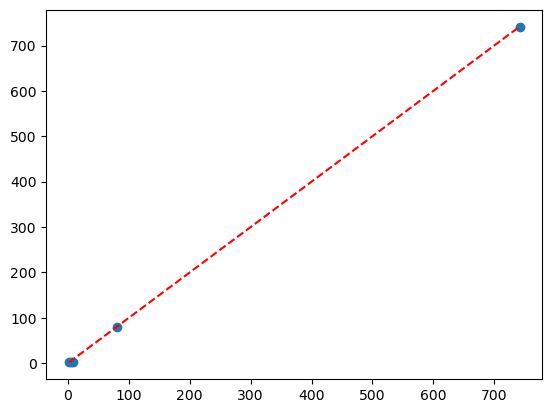

In [10]:
# test the model
out_nn = model.test_model(features)
# plot the results y vs y_nn
plt.scatter(target, out_nn.numpy())
plt.plot(target, target, 'r--')

In [11]:
# import numpy as np
# from scipy.stats import qmc

# def augment(a, b, t, init, n_samples=10):
#     '''Apply Latin Hypercube Sampling to the input data to generate more samples
#     '''

#     # echo number of samples to be generated
#     print(f'New samples to be generated\n {n_samples}')

#     # original data
#     original_data = np.vstack((a, b, t, init)).T
#     print(f'Original Data \n Min: {original_data.min(axis=0)} \n Max: {original_data.max(axis=0)}')

#     # obtain the range of each parameter
#     a_min, a_max = a.min(), a.max()
#     b_min, b_max = b.min(), b.max()
#     t_min, t_max = t.min(), t.max()
#     init_min, init_max = init.min(), init.max()

#     l_bound = np.array([a_min, b_min, t_min, init_min])
#     u_bound = np.array([a_max, b_max, t_max, init_max])

#     # check if the bounds are the same
#     assert len(l_bound) == len(u_bound), 'Lower and upper bounds do not match'
    
#     # apply Latin Hypercube Sampling
#     sampler = qmc.LatinHypercube(d=len(l_bound))
#     design_space = sampler.random(n_samples)
    
#     # convert the LHS samples (0, 1) to the actual range
#     new_design = qmc.scale(design_space, l_bound, u_bound)
#     print(f'New Design \n Min: {new_design.min(axis=0)} \n Max: {new_design.max(axis=0)}')

#     # merge the new samples with the original data and reshuflle
#     augmented_data = np.vstack((original_data, new_design))
#     np.random.shuffle(augmented_data)

#     # print summary
#     print(f'After merging \n Min: {augmented_data.min(axis=0)} \n Max: {augmented_data.max(axis=0)}')

#     return augmented_data
    
    

# # Example usage
# a = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
# b = np.array([0.25, 0.20, 0.15, 0.1, 0.05])
# t = np.array([0.5, 0.8, 1, 3, 5])
# init = np.array([0.75, 1.8 , 2.85, 3.9 , 4.95])

# augmented_data = augment(a, b, t, init, n_samples=50)